# ถ่ายรูปคู่กับมาสคอตประจำกลุ่มด้วย Stable Diffusion

<a target="_blank" href="https://colab.research.google.com/github/ai-builders/curriculum/blob/main/notebooks/icebreaking_dreambooth.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

โน้ตบุ๊คนี้จัดทำขึ้นเพื่อกิจกรรมปฐมนิเทศน์ [AI Builders](https://ai-builders.github.io/) 2023 ดัดแปลงมาจากโน้ตบุ๊คของ [cedro3/others3](https://github.com/cedro3/others3/blob/master/DreamBooth_02feb.ipynb) ใช้เวลาทำกิจกรรมประมาณ 1 ชั่วโมง (mentor/TA สอน 30 นาที + นักเรียนทำเอง 30 นาที)

จงสร้างรูป selfie ของตัวเองกับมาสคอตประจำกลุ่มแล้วส่งมาในห้อง #general เพื่อเป็นหลักฐาน **🔥 อย่าลืมเช็คว่า runtime เป็น GPU🔥** 

Stable Diffusion เป็นโมเดล open source โดย [Stability AI](https://stability.ai/) ที่สามารถสร้างรูปภาพจากคำบรรยายได้ **🔥ไม่ต้องกังวลหากตอนนี้คุณรู้สึกว่าตัวเองไม่รู้อะไรเลยเกี่ยวกับการทำงานของโมเดลนี้หรือโน้ตบุ๊คนี้🔥** สิ่งสำคัญของกิจกรรมนี้คือการได้ลองใช้งานโมเดล ML ชั้นนำและสนุกไปกับมัน คุณจะได้เรียนรู้ว่าแต่ละโมเดลทำงานยังไงอย่างละเอียดเท่าที่คุณต้องการตลอดระยะเวลาโครงการ



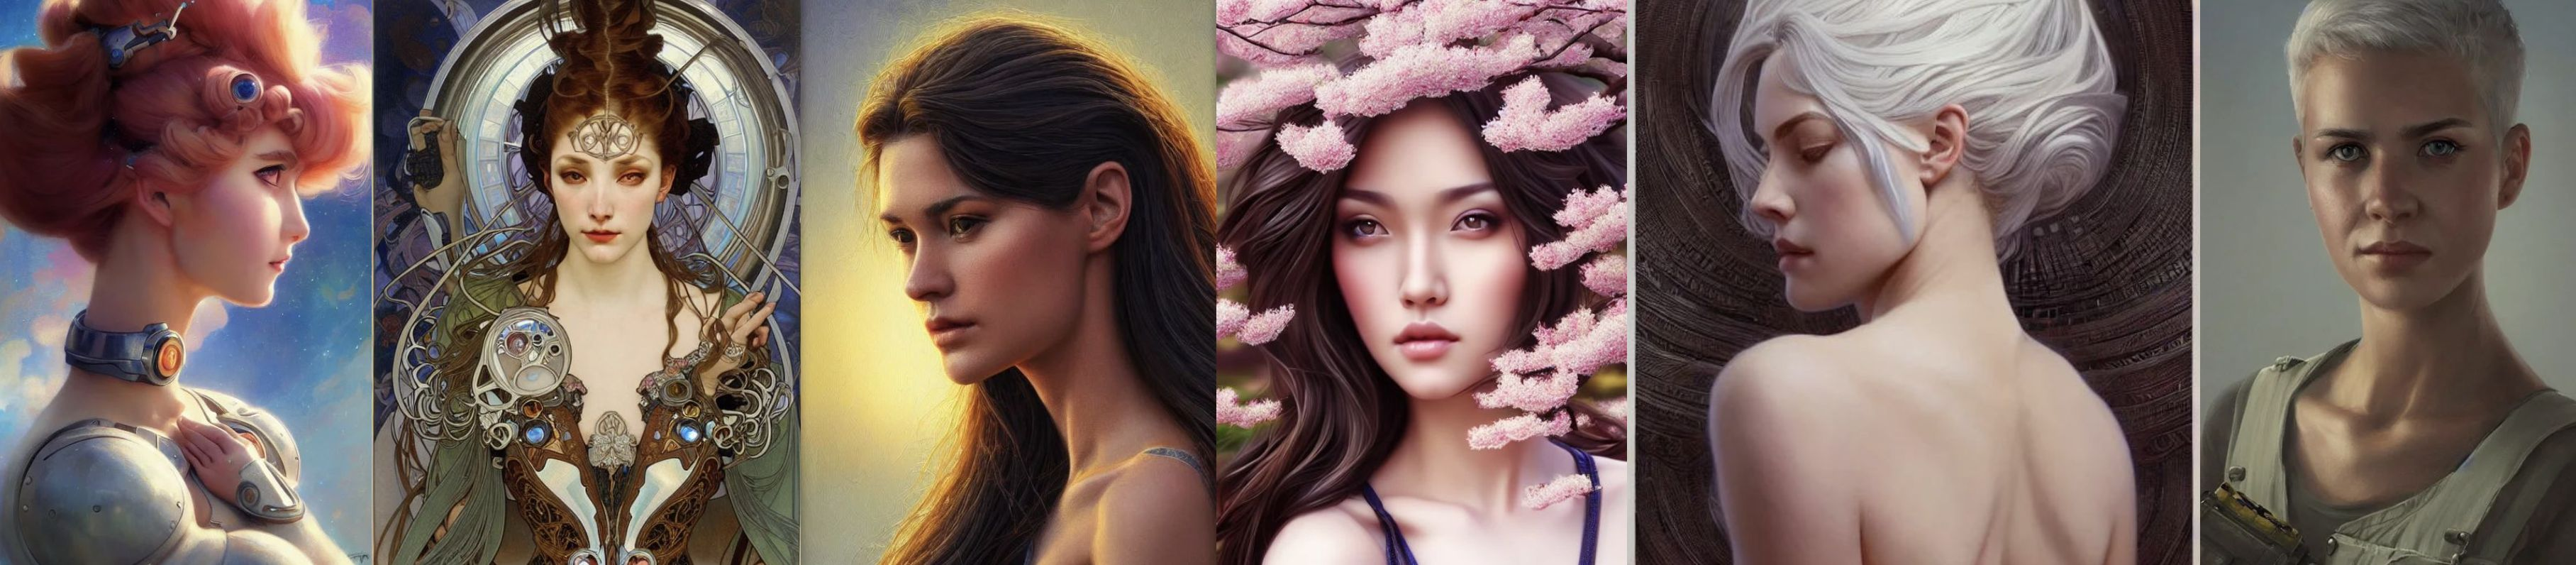


## ลง Library ที่จำเป็น

In [1]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 KB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## ล็อกอิน HuggingFace

คุณต้องยอมรับข้อตกลงของ Stable Diffusion ก่อนถึงจะใช้งานมันได้ ถ้าคุณยังไม่มีบัญชี HuggingFace ให้ไปสมัครแล้วหา Access Token มาจาก `Settings->Access Tokens`

In [2]:
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### สร้างชุดข้อมูลเพื่อทำการ Finetune โมเดล Stable Diffusion

เขียนชื่อคุณลงใน `INSTANCE:` เช่น `Somchai` กดรัน cell ด้านล่างเพื่อสร้าง folder ใน colab แล้วใส่รูป `.jpg` ลงไป 4-5 รูป (ชื่อไฟล์อาจจะเป็น `01.jpg`, `02.jpg`, ...)

`CLASS:` มีไว้สำหรับใส่สไตลด์ของรูป เช่น `selfie`, `portrait`, ...


In [3]:
# define function
import os
import shutil
def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import glob
def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()

# setting
MODEL_NAME = "CompVis/stable-diffusion-v1-4" 

INSTANCE = "charin"#@param {type:"string"}
INSTANCE_DIR = "/content/data/"+INSTANCE 
reset_folder(INSTANCE_DIR)

CLASS = "selfie" #@param {type:"string"}
CLASS_DIR = "/content/data/"+CLASS
reset_folder(CLASS_DIR)

OUTPUT_DIR = "/content/stable_diffusion_weights/" + INSTANCE
reset_folder(OUTPUT_DIR)


concepts_list = [
    {
        "instance_prompt":      INSTANCE,
        "class_prompt":         CLASS,
        "instance_data_dir":     INSTANCE_DIR,
        "class_data_dir":        CLASS_DIR
    },
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

## เช็ครูปสำหรับ Finetune

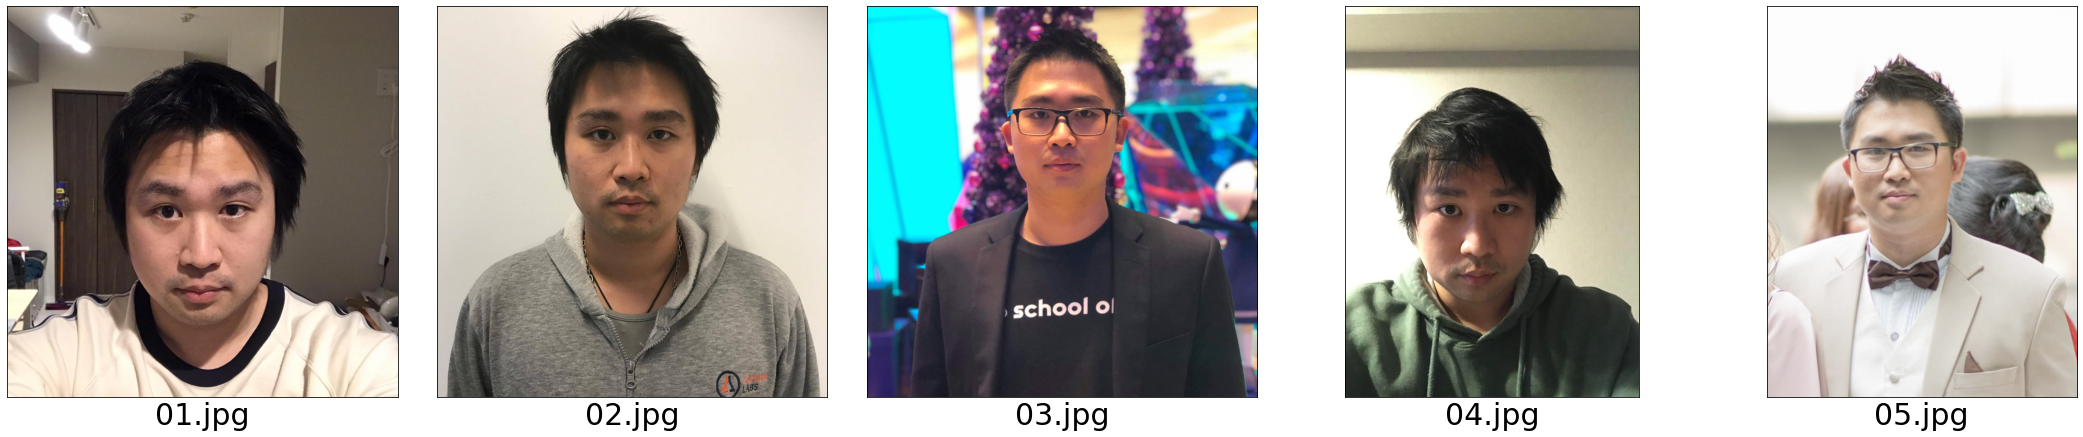

In [4]:
%matplotlib inline
display_pic(INSTANCE_DIR)

## Finetune โมเดลด้วยรูปของเราเอง

ถ้า `max_train_steps=800` จะใช้เวลาประมาณ 20 นาที

In [5]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=69420 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=400 \
  --save_interval=10000 \
  --save_sample_prompt=$CLASS \
  --concepts_list="concepts_list.json"


[06:27:22] WARNING  The following values were not passed to        ]8;id=318497;file:///usr/local/lib/python3.9/dist-packages/accelerate/commands/launch.py\launch.py]8;;\:]8;id=401659;file:///usr/local/lib/python3.9/dist-packages/accelerate/commands/launch.py#895\895]8;;\
                    `accelerate launch` and had defaults used                   
                    instead:                                                    
                            `--num_processes` was set to a value                
                    of `1`                                                      
                            `--num_machines` was set to a value of              
                    `1`                                                         
                            `--mixed_precision` was set to a value              
                    of `'no'`                                                   
                            `--dynamo_backend` was set to a value      

## Pipeline สำหรับสร้างรูปจากโมเดลที่ Finetune แล้ว

In [6]:
# Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" 
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR.rstrip(os.sep)+"/*"))[-1]

# Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

g_cuda = None

# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 69420 #@param {type:"number"}
g_cuda.manual_seed(seed)

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for u

## สร้างรูปจากโมเดลที่ Finetune แล้ว

รูปจะถูกเซฟไว้ที่ `images` ใช้เวลาสร้างประมาณ 1 นาทีสำหรับ 10 รูป (50 inference steps)

  0%|          | 0/50 [00:00<?, ?it/s]

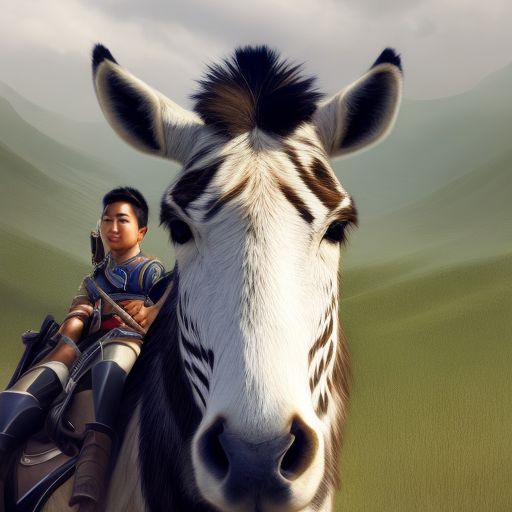

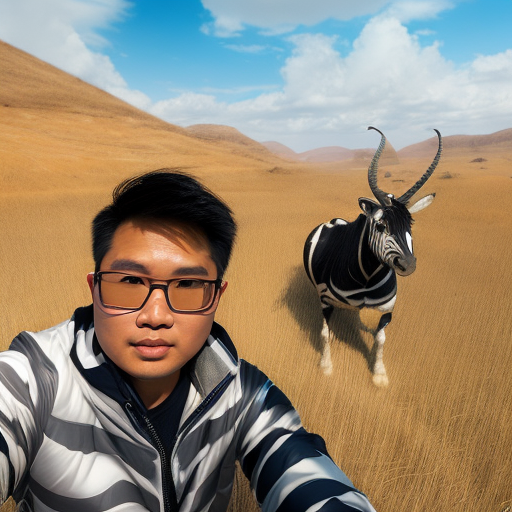

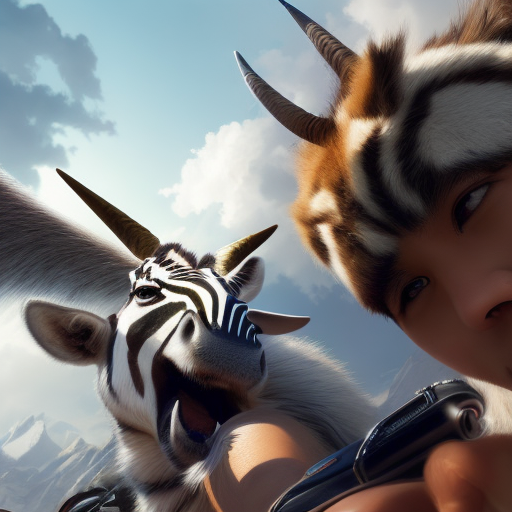

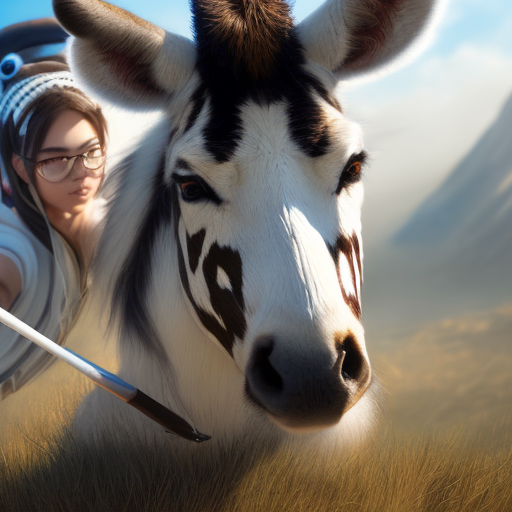

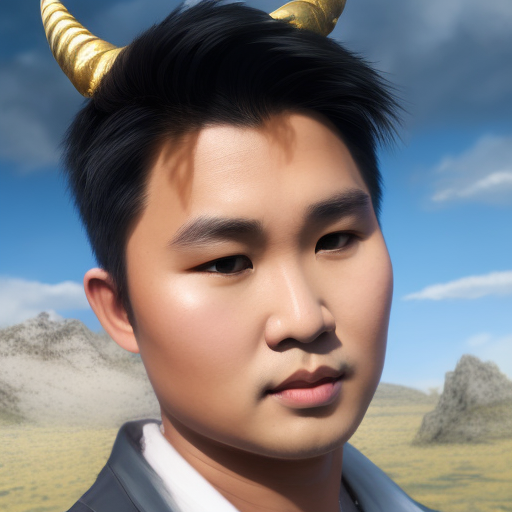

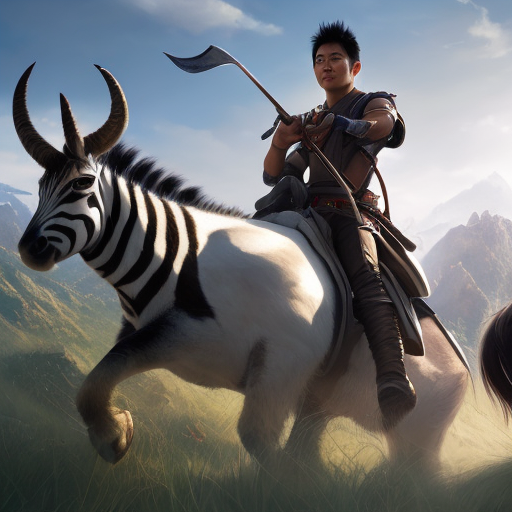

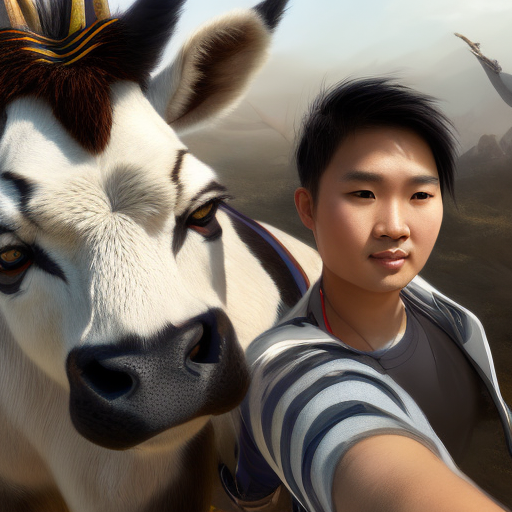

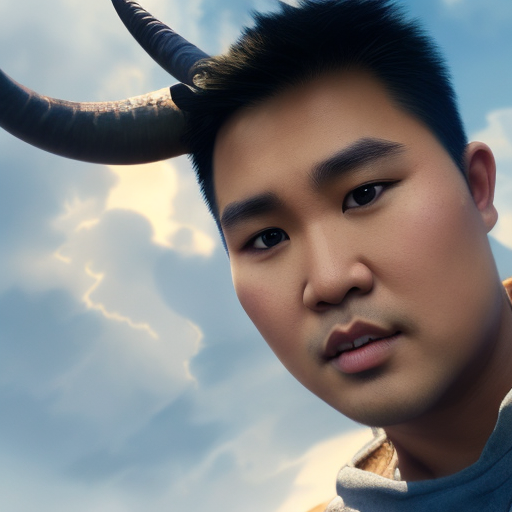

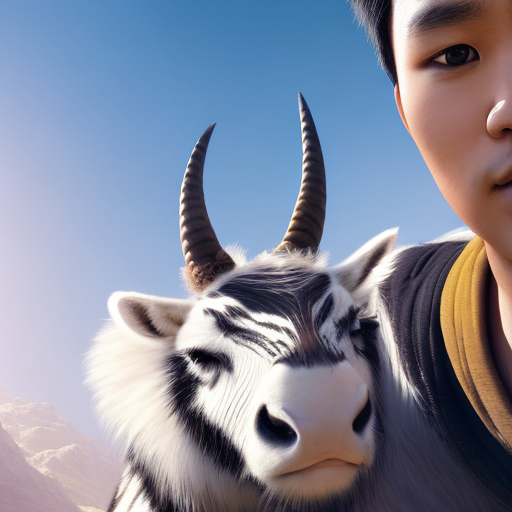

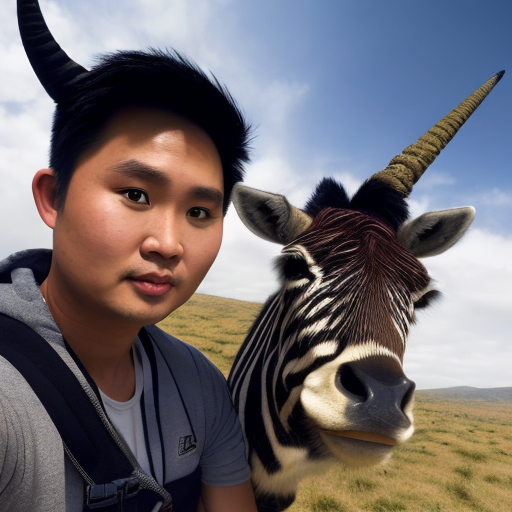

In [13]:
reset_folder('images')

# prompt
prompt = "selfie of charin and a horned zebra, concept art, natural lighting, illustration, full color, highly detailed, photorealistic, by greg rutkowski, artstation" #@param {type:"string"}
negative_prompt = "lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature" #@param {type:"string"}

# other setting
num_samples = 10 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512 

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for i, img in enumerate(images):
    img.save('images/'+str(i).zfill(4)+'.jpg')
    display(img)